In [584]:
# -*- coding=utf-8 -*-
# __author = 'bonnieting'__

# basic:
import pandas as pd
pd.set_option('display.float_format',lambda x:'%.2f' %x)
# pd.set_option('display.float_format', '{:.0f}'.format)
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import jieba
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
from itertools import product
import warnings
warnings.filterwarnings('ignore')
# time:
from datetime import datetime as dt
import time

# visual:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import plotly.express as px
from plotly import graph_objects as go
import plotly.figure_factory as ff
# import plotly.offline as pltol
# init_notebook_mode(connected=True)
import plotly as ply
ply.offline.init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import seaborn as sns
sns.set(style="whitegrid")

from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts import options as opts
from pyecharts.charts import Bar

# model:
from scipy.stats import norm
from pyecharts import options as opts
from scipy.stats.mstats import winsorize

# dataframe show_way:
from IPython.display import Markdown, display, HTML
# from IPython.display import display
# import os
# import sys
# sys.path.insert(0, '../common')
# from common_htmlTable import HtmlTableMulti
# from IPython.display import display, display_html

In [585]:
data=pd.read_csv(r"D:\repo_github\Portfolio\Portfolio1_sales_EDA\data\2019-Dec.csv")

# **Preliminery EDA**
***

## Data Overview

In [588]:
data.head()

event_time        event_type  product_id          category_id  \
0  2019-12-01 00:00:00 UTC  remove_from_cart     5712790  1487580005268456287   
1  2019-12-01 00:00:00 UTC              view     5764655  1487580005411062629   
2  2019-12-01 00:00:02 UTC              cart        4958  1487580009471148064   
3  2019-12-01 00:00:05 UTC              view     5848413  1487580007675986893   
4  2019-12-01 00:00:07 UTC              view     5824148  1487580005511725929   

  category_code      brand  price    user_id  \
0           NaN      f.o.x   6.27  576802932   
1           NaN        cnd  29.05  412120092   
2           NaN     runail   1.19  494077766   
3           NaN  freedecor   0.79  348405118   
4           NaN        NaN   5.56  576005683   

                           user_session  
0  51d85cb0-897f-48d2-918b-ad63965c12dc  
1  8adff31e-2051-4894-9758-224bfa8aec18  
2  c99a50e8-2fac-4c4d-89ec-41c05f114554  
3  722ffea5-73c0-4924-8e8f-371ff8031af4  
4  28172809-7e4a-45ce-bab0-5efa90117cd5

In [589]:
print(data.shape)
print(data.info())

(3533286, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533286 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 242.6+ MB
None


In [590]:
data.isnull().any()

event_time       False
event_type       False
product_id       False
category_id      False
category_code     True
brand             True
price            False
user_id          False
user_session      True
dtype: bool

In [591]:
data.nunique()

event_time       1654771
event_type             4
product_id         44624
category_id          482
category_code         10
brand                252
price               2122
user_id           370154
user_session      839812
dtype: int64

>- [ ] need to see the null in detail
>- [ ] build a scatterplot to see the time distribution of different behaviors.

## Global metrics

### total_uv & total_pv
_uv: unique visitor ; pv: page view; in total not in each 24hrs_

In [595]:
event_frequency = data['user_id'].value_counts()
print('event_frequency: \n' + str(event_frequency))
total_uv = len(event_frequency)
print('\ntotal_uv: '+str(total_uv))
total_pv = len(data['user_id'])
print('\ntotal_pv: '+str(total_pv))

event_frequency: 
user_id
527021202    8689
572631412    3883
467810091    3147
548810441    2426
584289031    2356
             ... 
561547151       1
586485554       1
586486068       1
363648439       1
595414541       1
Name: count, Length: 370154, dtype: int64

total_uv: 370154

total_pv: 3533286


### total_order
_total closing orders volume 总成交量_

In [597]:
total_order = len(data[data.event_type=='purchase']['user_session'].value_counts())
print('total_order: '+str(total_order))
#delete invalid column 删除无效列
# data.drop('category_code',axis=1,inplace=True)

total_order: 28894


### GMV
_gross merchandise volume(ignoring the returns and refunds) 总成交额/gmv（不考虑退货退款）_

In [599]:
total_gmv = data[data.event_type=='purchase']['price'].sum()
print('total_gmv: '+str(locale.currency(total_gmv,grouping = True))) # f'{total_gmv:.2f}'

total_gmv: $1,077,624.85


In [600]:
paid_user = data[data.event_type=='purchase'].nunique()['user_id']
Average_Purchase_Amount = total_gmv/paid_user
print('Average Purchase Amount (mean_amt_per_paid_user): ' + str(locale.currency(Average_Purchase_Amount,grouping = True)))

Average Purchase Amount (mean_amt_per_paid_user): $42.07


### price

In [602]:
data['price'].describe()

count   3533286.00
mean          8.87
std          19.86
min         -79.37
25%           2.06
50%           4.21
75%           7.14
max         327.78
Name: price, dtype: float64

> - [x] __need to clear the price <0__

### event type
_categorical statistics on purchase behavior 购买行为分类统计_

In [632]:
user_event_count = data['event_type'].value_counts()
print(user_event_count)

event_type
view                1728331
cart                 927124
remove_from_cart     664655
purchase             213176
Name: count, dtype: int64


> - [x] funnel model
> - [ ] how many views does a customer purchase after that in average?
> - [ ] how many views does a customer purchase the same one product after that in average?

## Rawdata Cleaning

In [634]:
data[['user_id','product_id','category_id','user_session']] = data[['user_id','product_id','category_id','user_session']].astype(str)
data.describe()

price
count 3533286.00
mean        8.87
std        19.86
min       -79.37
25%         2.06
50%         4.21
75%         7.14
max       327.78

In [636]:
data[data['price']<0]['product_id'].value_counts()

product_id
5670257    8
5716859    4
5716857    2
5716855    2
5716861    2
Name: count, dtype: int64

> should be the problem of these products. I need to see details by SQL from the product_table in database.
>
> put them into 0 for now.

In [639]:
# data['price'] = data['price'].where(data['price']<0, inplace=True)
data['price'] = data['price'].apply(lambda x: max(0, x))
data[data['price']<0]

Empty DataFrame
Columns: [event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session]
Index: []

In [660]:
data[(data['price']==0) & (data['event_type']=='purchase')]['category_id'].value_counts() # ['event_type'].value_counts()

category_id
1487580014042939619    18
Name: count, dtype: int64

> we can see all the price of view/cart/remove_from_cart type were set as 0 which meant 0 was normal.
> 
> the 18 records of free purchase had the same category_id and different product_id which may be free trial or something.

In [668]:
data[['category_code','brand','user_session']] = data[['category_code','brand','user_session']].fillna('null')
data.isnull().any()
# data[data['brand']=='null']

event_time       False
event_type       False
product_id       False
category_id      False
category_code    False
brand            False
price            False
user_id          False
user_session     False
dtype: bool

# **CUSTOMER ANALYSIS**
_by user_id_
***

## Key Point Indicators KPI 

### gross conversion rate 转化率
* *closign ratio 成交率 = unique_paid_user/total_uv*
* *total_paid_rate: What percentage of people who buy, among all the people who browse, add, and buy*

In [35]:
view_user = data[data.event_type=='view'].nunique()['user_id']
print('view_user: '+str(view_user))
total_view_rate = (view_user/total_uv)*100
print('total_view_rate: '+str('%.2f'%total_view_rate)+'%')

cart_user = data[data.event_type=='cart'].nunique()['user_id']
print('\ncart_user: '+str(cart_user))
total_cart_rate = (cart_user/total_uv)*100
print('total_cart_rate: '+str('%.2f'%total_cart_rate)+'%')
cart_pct_inview = (cart_user/view_user)*100
print('cart_pct_inview: '+str('%.2f'%cart_pct_inview)+'%')

# pre-defined: paid_user = data[data.event_type=='purchase'].nunique()['user_id']
print('\npaid_user: '+str(paid_user)) # '%.0f'%
total_paid_rate = (paid_user/total_uv)*100
print('total_paid_rate: '+str('%.2f'%total_paid_rate)+'%')
paid_pct_incart = (paid_user/cart_user)*100
print('paid_pct_incart: '+str('%.2f'%paid_pct_incart)+'%')
paid_pct_inview = (paid_user/view_user)*100
print('paid_pct_inview: '+str('%.2f'%paid_pct_inview)+'%')

view_user: 358212
total_view_rate: 96.77%

cart_user: 83458
total_cart_rate: 22.55%
cart_pct_inview: 23.30%

paid_user: 25613
total_paid_rate: 6.92%
paid_pct_incart: 30.69%
paid_pct_inview: 7.15%


> - User behavior flow path:
> 1. view->cart->purchase
> 2. view->purchase
> 3. open app->purchase directly
> 
> - [ ] group by user_id, product_id, in/ not in one user_session
> - [ ] how long does a customer cost in each link in one user session? -> need more data 

#### funnelplot

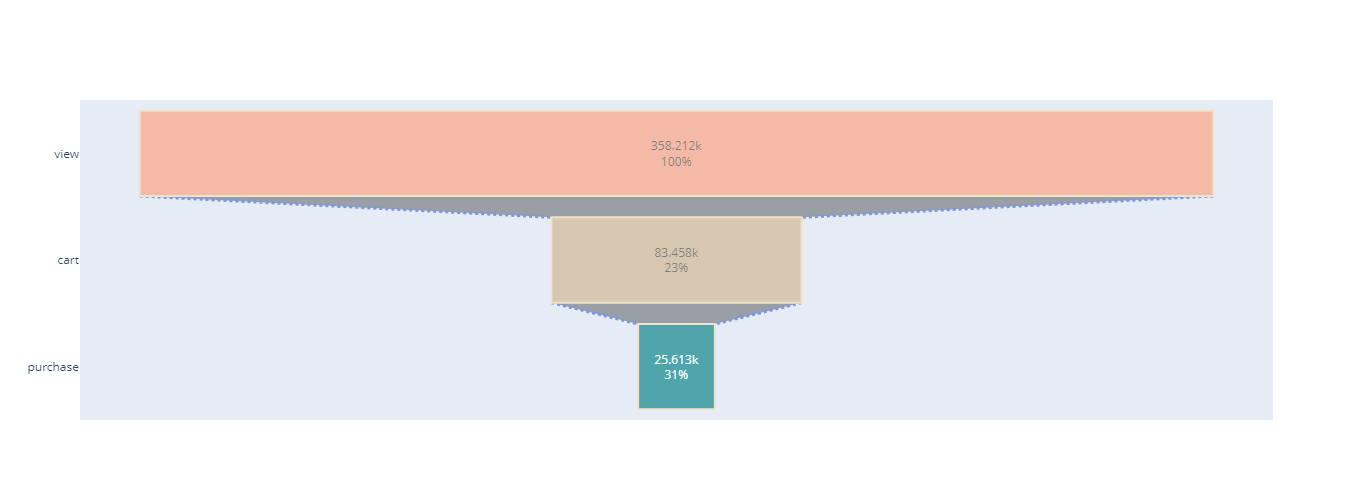

In [38]:
fig = go.Figure(go.Funnel(
    y = ["view", "cart", "purchase"],
    x = [view_user, cart_user, paid_user],
    textposition = "inside",
    textinfo = "value + percent previous",
    opacity = 0.65, marker = {"color": ["lightsalmon", "tan", "teal"],
    "line": {"width": [2, 2, 2], "color": ["wheat", "wheat", "wheat",]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(width=1000, height=500)
fig.show()

#### CVR insights
- [ ] need a reference object to decide if the flow percentages are lower than normal ones.(Maybe data from competitive products or the benchmark of a specific field.) -> need more data
- [ ] Nevertheless, only 23% from view to cart is not enough. I think usually the first thing is to check if there are tremendous diffs between brands which means the product media materials(pics or vedios) matter a lot if yes.
    - One Step Forward, we can do simple ABTest on materials with Product Department to verify the hypothesis.
    - Two step forward, we need Marketing Department to do more optimizing the overall quality of materials. For example,
        - Give good examples of materials
        - Regularly update with a series of training courses that teach brand stores how to optimize materials well
        - Emphasize the importance of materials when merchants enter the platform
        - Or even develop a new backend feature that automatically generates and beautifies materials
- if it's not materials, it could be:
    - recommender system needs optimizing: products dont meet their needs.
    - unfriendly interface: the confusing function button in the converting page
    - the unreasonable price: like higher than competition
    - the website experience issues: like loading slowly or a complicated process or unstable connection

### purchase frequency 用户购买频率
_Distribution of buying times per user 用户购买次数分布_

In [41]:
user_buy_times = data[data.event_type=='purchase'].groupby('user_id').count()['user_session'] 
# output Series，should we calculate the frequency in the all "purchase" users or in the all? I think the former making sense.
user_buy_times

user_id
101025416    11
103274988    17
105075440     2
105118203     8
105379623     6
             ..
98079173     14
99011711      4
99293243      7
99499363      8
99666343      1
Name: user_session, Length: 25613, dtype: int64

In [42]:
user_buy_times.describe()

count   25613.00
mean        8.32
std        10.74
min         1.00
25%         3.00
50%         5.00
75%        10.00
max       399.00
Name: user_session, dtype: float64

In [43]:
print('max_buying_times: ' + str(user_buy_times.max()))
print('min_buying_times: ' + str(user_buy_times.min()))
Average_Purchase_Frequency = user_buy_times.mean()
print('Average Purchase Frequency (mean_buying_times_per_paid_user): ' + str('%.2f'%Average_Purchase_Frequency))
# buy_times_over20 = user_buy_times.values > 20
# buy_times_over20 = np.count_nonzero(buy_times_over20)
# buy_times_over20 = np.sum(buy_times_over20)
# buy_times_over20

max_buying_times: 399
min_buying_times: 1
Average Purchase Frequency (mean_buying_times_per_paid_user): 8.32


In [44]:
buy_times_within_20 = len(user_buy_times[(user_buy_times >= 0) & (user_buy_times <= 20)])
print('Buying_times between [0-20]: ' + str(buy_times_within_20))
buy_times_within_20_ratio = (buy_times_within_20 / paid_user)*100
print("Buying_times between [0-20] ratio: ", str('%.2f'%buy_times_within_20_ratio)+'%')

Buying_times between [0-20]: 23701
Buying_times between [0-20] ratio:  92.54%


#### frequency distribution histplot
_to see how many users bought how many times 有多少用户买了XX次_

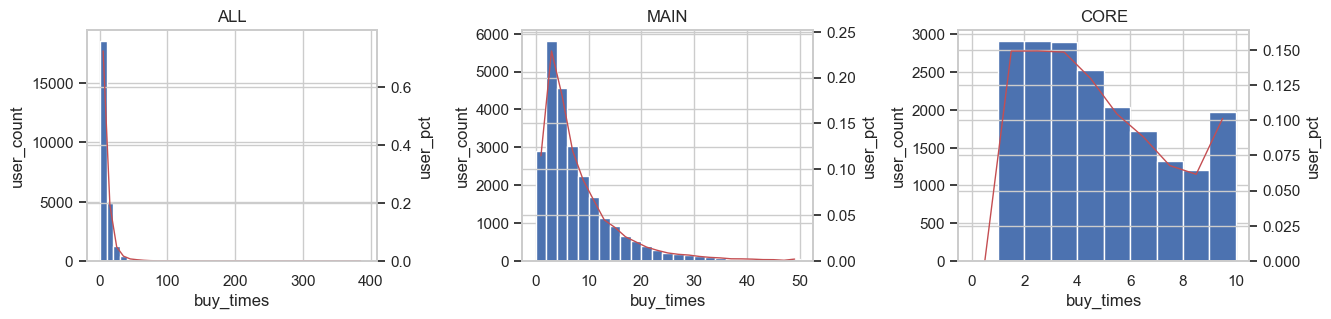

In [499]:
def plot_histogram(ax, data, title, bins):
    n, bins, patches = ax.hist(x=data, bins=bins, density=False)
    ax.set_xlabel('buy_times')
    ax.set_ylabel('user_count')

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    freq = n / n.sum()

    ax2 = ax.twinx()
    ax2.plot(bin_centers, freq, 'r-', linewidth=1.0)
    ax2.set_ylabel('user_pct')
    ax2.set_ylim([0, freq.max() * 1.1])
    ax.set_title(title)

    return ax, ax2 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
plt.subplots_adjust(wspace=0.5)

plot_histogram(axes[0], user_buy_times, 'ALL', np.arange(0, 400, 10))
plot_histogram(axes[1], user_buy_times[user_buy_times.values<51], 'MAIN', np.arange(0, 51, 2))
plot_histogram(axes[2], user_buy_times[user_buy_times.values<11], 'CORE', np.arange(0, 11, 1))

plt.show()

In [47]:
print('times data was split into ' + str(len(n)) + ' groups by steplength: 10 .')
freq = freq.tolist()
freq = [f'{f*100:.2f}'+'%' for f in freq]
df1 = pd.DataFrame({'Buying_times From': bins[:-1], 'Buying_times To': bins[1:], 'Frequency': n, 'Normalized Frequency': freq})
df1.head(13)

times data was split into 39 groups by steplength: 10 .


Buying_times From  Buying_times To  Frequency Normalized Frequency
0                0.00            10.00   18568.00               72.50%
1               10.00            20.00    4929.00               19.24%
2               20.00            30.00    1247.00                4.87%
3               30.00            40.00     426.00                1.66%
4               40.00            50.00     181.00                0.71%
5               50.00            60.00     111.00                0.43%
6               60.00            70.00      60.00                0.23%
7               70.00            80.00      29.00                0.11%
8               80.00            90.00      15.00                0.06%
9               90.00           100.00      15.00                0.06%
10             100.00           110.00       8.00                0.03%
11             110.00           120.00       4.00                0.02%
12             120.00           130.00       5.00                0.02%

> - [ ] can build the VIP system or Key Customers list from the buying_times & buying_amount

### repurchase rate 用户复购率 
_number of users who bought more than once 复购率（购买次数在2次及以上的人数/有过购买记录的人数）_

In [50]:
twice_buy_user=user_buy_times[user_buy_times>=2].count()
twice_buy_user
rebuy_rate=(twice_buy_user/paid_user)*100
print('rebuy_rate: '+str('%.2f'%rebuy_rate)+'%')
# print("复购率:{:.2f}%".format(rebuy_rate*100))

rebuy_rate: 88.64%


#### rebuy insights
- rebuy_rate: 88.64% even though 75% user never bought more than 10 times, which means the customer loyalty of this platform is nearly perfect. (I will set "raising rebuy_times of all rebuy customers" aside from "raising rebuy_rate of all paid customers" which are two different things.)
- So the point will be "let customers choose us once."(dont need to be the first exposure just need one chance to make a try--> "free trial on deliver-cost or cosmetics samples for women" would be nice to move forward). Besides, the point will be:
    - on the Marketing Deparment to gain trust in the exposures by compelling pictures or videos,
    - or on the PM Team to design a function to showcase rates, comments, star-level of brands/products,
    - or on the Referral Algorithm Team to optimize the contents in cover-feed and search results.
- [ ] how long does a customer cost to rebuy after the first bought in average (to further determine the health) ?
- [ ] how long between two buying actions of one user in average ?

### churn cate 用户流失率
_rate of customers who gave up using or buying on our platform 放弃使用、不再活跃的用户比率 reduce churn rate to retain more customers._

- unique users only view / total_uv
- unique users only cart (not to purchase / total_uv
- unique users only buy once / total_uv

In [53]:
# we have variable: event_frequency = data['user_id'].value_counts() = data.groupby('user_id').count()['user_session']
once_buy_user = user_buy_times[user_buy_times==1].count()
once_buy_rate = (once_buy_user/total_uv)*100
print('once_buy_churn_rate: '+str('%.2f'%once_buy_rate)+'%')

once_buy_churn_rate: 0.79%


In [54]:
event_type_df = data.groupby(['user_id', 'event_type']).count().reset_index()
df3 = event_type_df[event_type_df['event_type']=='view']['user_id']
user_event_type_nums = event_type_df.groupby('user_id').count()['user_session']
user_event_type_nums
only_view_user = len(set(user_event_type_nums[user_event_type_nums==1].index).intersection(set(df3.values)))
only_view_rate = (only_view_user/total_uv)*100
print('only_view_churn_rate: '+str('%.2f'%only_view_rate)+'%')

only_view_churn_rate: 76.80%


In [55]:
df5 = event_type_df[event_type_df['event_type']=='cart']['user_id']
cart_no_buy = len(set(df5.values).difference(set(user_buy_times.index)))
cart_no_buy_rate = (cart_no_buy/len(df5))*100
print(str(cart_no_buy) + ' persons in 83458 cart customers didn\'t go to purchase. The only_cart churn rate for the very cart link is: ' + str('%.2f'%cart_no_buy_rate) + '%.')

cart_no_buy_rate_intotal = (cart_no_buy/total_uv)*100
print('only_cart_churn_rate: ' +str('%.2f'%cart_no_buy_rate_intotal) + '%.')

58168 persons in 83458 cart customers didn't go to purchase. The only_cart churn rate for the very cart link is: 69.70%.
only_cart_churn_rate: 15.71%.


In [56]:
cart_from_view = len(set(set(df5.values).intersection(set(df3.values))))
cart_from_view_rate = (cart_from_view/len(df5))*100
print(str(cart_from_view) + ' persons in 83458 cart customers came from view. The rate is: ' + str('%.2f'%cart_from_view_rate) + '%.')

72359 persons in 83458 cart customers came from view. The rate is: 86.70%.


In [57]:
print('The total churn rate is: ' + str('%.2f'%sum([once_buy_rate, cart_no_buy_rate_intotal, only_view_rate])) + '%.')

The total churn rate is: 93.30%.


#### churn rate insights
- which means the churn rate of **cart_without_buy** and **only_view**  is not low even though the repurchase rate is highly to 88.64%. So we team should focus on **how to let people try just once**. For reference:
    - increasing the conversion rate in user flow to enhance the purchase on the end
    - holding offer campaigns to drawing people to order for the first time
    - guiding customers to make decision: like providing "compare"/"rating" function or lightening the crucial comments
    - collecting feedback and making improvements

(similiar conclusions to the rebuy insights)
- cart_without_buy includes customers who view to cart and just cart directly.
**the part in view customers went to purchase is 30.3% from "The only_cart_churn_rate is: 69.70%", less than paid_pct_incart=30.69% in conversion rate chapter by 0.387% because 323 customers purchased directly after view without add to cart, which also means 98.74% of purchase came from cart, a essential function.**

## Customer Lifetime Value LTV 用户生命周期价值
_Refined operation of users_

### total LTV
_total_LTV = Average Customer Lifespan * Average Purchase Frequency * Average Purchase Amount_

In [61]:
event_time_df = data[data.event_type=='purchase'].groupby('user_id')['event_time'].agg(['min', 'max', 'count']).rename(columns={'min':'min_time', 'max':'max_time', 'count':'time_times'}) # last buy time - first buy time = lifespan (not first/last event time)
# event_time_df['daysdiff'] = dt.date(event_time_df['max_time']) - dt.date(event_time_df['min_time']) # TypeError: 'Series' object cannot be interpreted as an integer
event_time_df['daysdiff'] = (pd.to_datetime(event_time_df['max_time']) - pd.to_datetime(event_time_df['min_time'])).dt.days + 1
event_time_df = event_time_df.sort_values(by='daysdiff', ascending=False)
event_time_df

min_time                 max_time  time_times  \
user_id                                                                   
474001917  2019-12-01 11:56:38 UTC  2019-12-31 14:02:46 UTC          56   
579991254  2019-12-01 01:42:52 UTC  2019-12-30 05:53:18 UTC          12   
475372718  2019-12-02 04:02:01 UTC  2019-12-31 17:04:27 UTC          55   
485997000  2019-12-03 07:10:41 UTC  2019-12-31 17:08:36 UTC           8   
574105439  2019-12-02 18:01:44 UTC  2019-12-31 00:03:18 UTC          28   
...                            ...                      ...         ...   
525835919  2019-12-24 09:44:55 UTC  2019-12-24 09:44:55 UTC           9   
525831399  2019-12-05 11:56:53 UTC  2019-12-05 11:56:53 UTC           3   
525821970  2019-12-28 11:31:11 UTC  2019-12-28 11:31:11 UTC          33   
525783622  2019-12-21 18:58:08 UTC  2019-12-21 18:58:08 UTC           3   
99666343   2019-12-17 18:27:15 UTC  2019-12-17 18:27:15 UTC           1   

           daysdiff  
user_id              
474001917        31  
579991254        30  
475372718        30  
485997000        29  
574105439        29  
...             ...  
525835919         1  
525831399         1  
525821970         1  
525783622         1  
99666343          1  

[25613 rows x 4 columns]

In [62]:
# effective_event_time_df = event_time_df[event_time_df['daysdiff']>0]
mean_daysdiff = event_time_df['daysdiff'].agg('mean')
print('Average Customer Lifespan: ' + str('%.2f'%mean_daysdiff) + ' days.')
event_time_df['daysdiff'].describe()
# effective_event_time_df['daysdiff'].describe() # same as above

Average Customer Lifespan: 1.84 days.


count   25613.00
mean        1.84
std         3.44
min         1.00
25%         1.00
50%         1.00
75%         1.00
max        31.00
Name: daysdiff, dtype: float64

In [63]:
Average_Customer_Lifespan = mean_daysdiff
LTV = Average_Customer_Lifespan * Average_Purchase_Frequency * Average_Purchase_Amount

print('Customer Lifetime Value: $' + str('%.2f'%LTV))

Customer Lifetime Value: $644.15


In [64]:
monthly_cvalue = Average_Purchase_Frequency * Average_Purchase_Amount
print('Monthly Customer Value: Per paid customer brought $' + str('%.2f'%monthly_cvalue) + ' in average per month.') 

Monthly Customer Value: Per paid customer brought $350.17 in average per month.


In [65]:
daysdiff_1 = event_time_df[event_time_df.daysdiff == 1]['daysdiff'].count()
print(daysdiff_1, 'much more than' ,once_buy_user)

23571 much more than 2910


> TIPS
>
> daysdiff == 1 does not mean that he only bought once. run: `data[(data.user_id == 525324399) & (data.event_type == 'purchase')]` . 
>
> U'll find he bought 9 times at the same vent time 2019-12-11 20:32:06 UTC. I guess it was a compaign starting poin like Double12 (12, Dec each year). More like robot order manipulation in flash sale.

### precised LTV by RFM model
_segment all customers into 2^3=8 sections by LTV from RFM computing_

In [68]:
# buy_df = data[data.event_type=='purchase'].groupby('user_id')
event_time_df['max_time2'] = pd.to_datetime(event_time_df['max_time'].str[:-4],utc=True, format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None) # YYYY-MM-DDTHH-MM-SS,, errors='coerce'
analysis_date = event_time_df['max_time2'].max().replace(hour=23, minute=59, second=59) # datetime.today().date() or (event_time_df['max_time2'].max() + pd.DateOffset(days=1)).date()
event_time_df['lastbuy_interval'] =  (analysis_date - event_time_df['max_time2']).dt.days
recency_data = event_time_df['lastbuy_interval'].max() - event_time_df['lastbuy_interval'] # !!I change it into "lifespan" so that the longer lifespan, the higher R-score, that's logical now.

monetary_data = data[data.event_type=='purchase'].groupby('user_id')['price'].sum()

rfm_df = pd.DataFrame({'Recency': recency_data, 'Frequency': user_buy_times, 'Monetary': monetary_data})
rfm_df

Recency  Frequency  Monetary
user_id                                
101025416       17         11     62.10
103274988        1         17     60.63
105075440       22          2     11.30
105118203       20          8     39.58
105379623        9          6     20.08
...            ...        ...       ...
98079173        19         14     31.43
99011711        27          4     32.86
99293243        17          7     50.93
99499363         3          8     39.32
99666343        16          1      4.00

[25613 rows x 3 columns]

> I found the robustness of the 3 dimensions was really high, which meant the model was sensitive to outliers. So I need to exclude outliers first.

In [70]:
# exclude extremum values by percentile
recency_pct = rfm_df['Recency'].quantile([0.01, 0.99])
frequency_pct = rfm_df['Frequency'].quantile([0.01, 0.99])
monetary_pct = rfm_df['Monetary'].quantile([0.01, 0.99])

rfm_df = rfm_df[(rfm_df['Recency'] >= recency_pct.iloc[0]) & (rfm_df['Recency'] <= recency_pct.iloc[1])]
rfm_df = rfm_df[(rfm_df['Frequency'] >= frequency_pct.iloc[0]) & (rfm_df['Frequency'] <= frequency_pct.iloc[1])]
rfm_df = rfm_df[(rfm_df['Monetary'] >= monetary_pct.iloc[0]) & (rfm_df['Monetary'] <= monetary_pct.iloc[1])]

In [71]:
rfm_df['R'], r_bins= pd.qcut(rfm_df['Recency'], q=10, labels=False, retbins=True) # labels=True, retbins=True
rfm_df['F'], f_bins = pd.qcut(rfm_df['Frequency'], q=10, labels=False, retbins=True, duplicates='drop')
rfm_df['M'], m_bins = pd.qcut(rfm_df['Monetary'], q=10, labels=False, retbins=True)

rfm_df['RFM_Score'] = 0.2*rfm_df['R'] + 0.3*rfm_df['F'] + 0.5*rfm_df['M'] # [0.1,0.3,0.6]the weight was decided according to what we cared most.
rfm_df['LTV'] = rfm_df['RFM_Score'] * Average_Purchase_Amount

print("Recency bins:", r_bins)
print("Frequency bins:", f_bins)
print("Monetary bins:", m_bins)
# rfm_df = rfm_df.sort_values(by='LTV', ascending=False)
rfm_df # .reset_index()

Recency bins: [ 0.  3.  6.  9. 11. 15. 17. 20. 22. 25. 29.]
Frequency bins: [ 1.  2.  3.  4.  5.  7.  9. 12. 17. 50.]
Monetary bins: [  3.67   10.44   13.404  17.3    21.98   28.21   36.012  43.92   54.9
  79.158 248.08 ]


Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV
user_id                                                           
101025416       17         11     62.10  5  6  8       6.80 286.10
103274988        1         17     60.63  0  7  8       6.10 256.65
105075440       22          2     11.30  7  0  1       1.90  79.94
105118203       20          8     39.58  6  5  6       5.70 239.82
105379623        9          6     20.08  2  4  3       3.10 130.43
...            ...        ...       ... .. .. ..        ...    ...
98079173        19         14     31.43  6  7  5       5.80 244.03
99011711        27          4     32.86  9  2  5       4.90 206.16
99293243        17          7     50.93  5  4  7       5.70 239.82
99499363         3          8     39.32  0  5  6       4.50 189.33
99666343        16          1      4.00  5  0  0       1.00  42.07

[24813 rows x 8 columns]

In [72]:
rfm_df[['Recency', 'Frequency', 'Monetary','LTV']].describe()

Recency  Frequency  Monetary      LTV
count 24813.00   24813.00  24813.00 24813.00
mean     14.19       7.63     38.37   173.59
std       8.12       7.31     33.66    88.86
min       0.00       1.00      3.67     0.00
25%       8.00       3.00     15.36   100.98
50%      15.00       5.00     28.21   172.50
75%      21.00      10.00     48.41   244.03
max      29.00      50.00    248.08   366.04

> notice that the mean_LTV=366.04 is not a real dollar number but a relative score in total purchase group, a self_defined weight. So it's normal that it != $350.17 from last chapter.

#### RFM destribution histplot

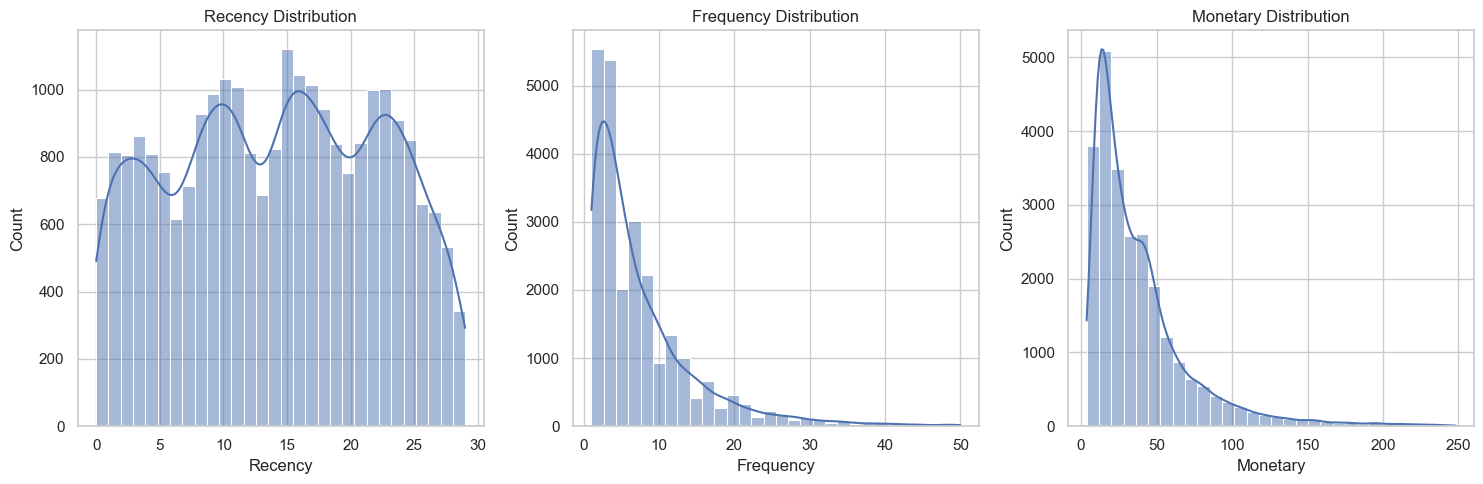

In [75]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(rfm_df['Recency'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm_df['Frequency'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm_df['Monetary'], bins=30, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

> - [ ] the recency shows that lifespan of customers has obviously periodic. To see insider.

## User Segmentation 用户分层
_segment all customers into 2^3=8 sections by LTV from RFM computing_
### segmentation criteria 3Dscatterplot

In [78]:
rfm_df2 = rfm_df.reset_index()
fig = px.scatter_3d(rfm_df2, x='Recency', y='Frequency', z='Monetary', color='RFM_Score',
                    size='RFM_Score', opacity=0.5, size_max=10, hover_name='user_id', #symbol='user_id',
                    title='RFM User Segmentation Cube')

fig.update_layout(scene=dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'))
fig.update_layout(width=1000, height=800)

# add straight line to present the 8 subcubes spliting by 50% quantiles above: R-15 F-5 M-28.17
lines_x = [[0,30],[0,30],[0,30],[0,30],[0,30],[0,30],[0,30],[0,30]]
lines_y = [[0,0],[50,50],[0,0],[5,5],[50,50],[0,0],[5,5],[50,50]]
lines_z = [[28.17,28.17],[28.17,28.17],[0,0],[0,0],[0,0],[250,250],[250,250],[250,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False))

In [79]:
lines_x = [[0,0],[30,30],[0,0],[15,15],[30,30],[0,0],[15,15],[30,30]]
lines_y = [[0,50],[0,50],[0,50],[0,50],[0,50],[0,50],[0,50],[0,50]]
lines_z = [[28.17,28.17],[28.17,28.17],[0,0],[0,0],[0,0],[250,250],[250,250],[250,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False)) 

In [80]:
lines_x = [[15,15],[15,15],[0,0],[0,0],[0,0],[30,30],[30,30],[30,30]]
lines_y = [[0,0],[50,50],[0,0],[5,5],[50,50],[0,0],[5,5],[50,50]]
lines_z = [[0,250],[0,250],[0,250],[0,250],[0,250],[0,250],[0,250],[0,250]]
for i in range(len(lines_x)):
    fig.add_trace(go.Scatter3d(x=lines_x[i], y=lines_y[i], z=lines_z[i], mode='lines', line=dict(color='black', width=3), name='Line {}'.format(i + 1), showlegend=False))

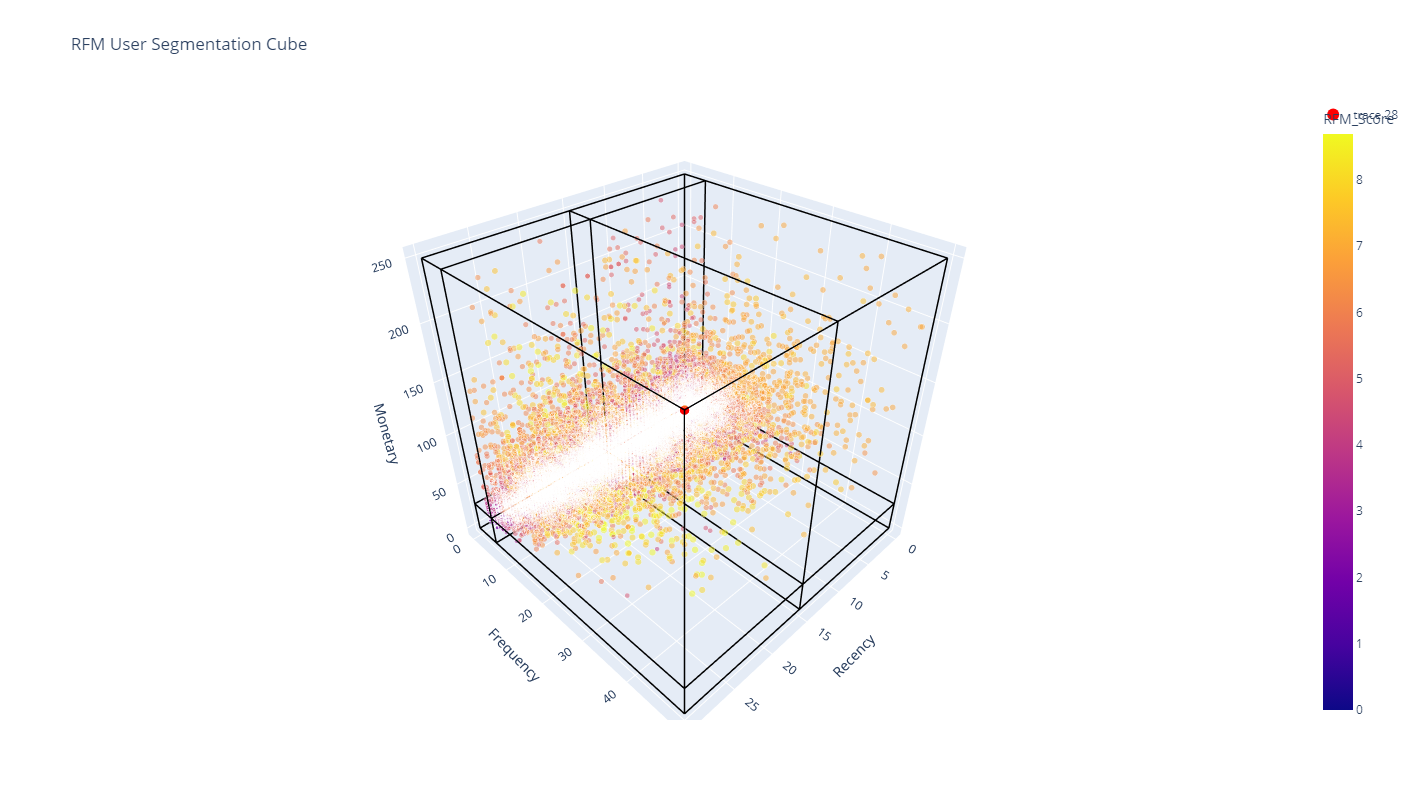

In [81]:
fig.add_trace(go.Scatter3d(x=[15,15], y=[0,50], z=[28.17,28.17], mode='lines', line=dict(color='black', width=3), showlegend=False)) # legendgroup='divide_R', legendrank=1500 , legendgrouptitle={'text':'Segment'}
fig.add_trace(go.Scatter3d(x=[0, 30], y=[5,5], z=[28.17,28.17], mode='lines', line=dict(color='black', width=3), showlegend=False))
fig.add_trace(go.Scatter3d(x=[15, 15], y=[5,5], z=[0, 250], mode='lines', line=dict(color='black', width=3), showlegend=False))

# add center point
fig.add_trace(go.Scatter3d(x=[15], y=[25], z=[125],
                           mode='markers', marker=dict(color='red', size=5),
                           text=['(15,25,125)'], textposition='middle center'))

fig.show()

In [82]:
rfm_df2['group'] = ''
for i in range(0,len(rfm_df2)):
    if rfm_df2['R'][i]<5:
        if rfm_df2['F'][i]<5:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='000'
            else:
                rfm_df2['group'][i]='001'
        else:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='010'
            else:
                rfm_df2['group'][i]='011'
    else:
        if rfm_df2['F'][i]<5:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='100'
            else:
                rfm_df2['group'][i]='101'
        else:
            if rfm_df2['M'][i]<5:
                rfm_df2['group'][i]='110'
            else:
                rfm_df2['group'][i]='111'
rfm_df2['group'] = rfm_df2['group'].astype(str)

In [83]:
rfm_df2

user_id  Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV  \
0      101025416       17         11     62.10  5  6  8       6.80 286.10   
1      103274988        1         17     60.63  0  7  8       6.10 256.65   
2      105075440       22          2     11.30  7  0  1       1.90  79.94   
3      105118203       20          8     39.58  6  5  6       5.70 239.82   
4      105379623        9          6     20.08  2  4  3       3.10 130.43   
...          ...      ...        ...       ... .. .. ..        ...    ...   
24808   98079173       19         14     31.43  6  7  5       5.80 244.03   
24809   99011711       27          4     32.86  9  2  5       4.90 206.16   
24810   99293243       17          7     50.93  5  4  7       5.70 239.82   
24811   99499363        3          8     39.32  0  5  6       4.50 189.33   
24812   99666343       16          1      4.00  5  0  0       1.00  42.07   

      group  
0       111  
1       011  
2       100  
3       111  
4       000  
...     ...  
24808   111  
24809   101  
24810   101  
24811   011  
24812   100  

[24813 rows x 10 columns]

In [84]:
a = [1,0]
b = [1,0]
c=[1,0]

comb = list(product(a, b,c))
gpn_df = pd.DataFrame(np.array(comb), columns=['Rs', 'Fs', 'Ms'])
gpn_df['group'] = gpn_df.apply(lambda row: ''.join(map(str, row)), axis=1)
gpn_df['tags'] = ['champions','promising','potentital_loyalist','newcome','former_loyalist','at_risk','hibernating','almost_lost']
gpn_df['group'] = gpn_df['group'].astype(str)
gpn_df

Rs  Fs  Ms group                 tags
0   1   1   1   111            champions
1   1   1   0   110            promising
2   1   0   1   101  potentital_loyalist
3   1   0   0   100              newcome
4   0   1   1   011      former_loyalist
5   0   1   0   010              at_risk
6   0   0   1   001          hibernating
7   0   0   0   000          almost_lost

In [85]:
gpn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rs      8 non-null      int32 
 1   Fs      8 non-null      int32 
 2   Ms      8 non-null      int32 
 3   group   8 non-null      object
 4   tags    8 non-null      object
dtypes: int32(3), object(2)
memory usage: 356.0+ bytes


In [86]:
rfm_df3 = pd.merge(rfm_df2, gpn_df, on='group', how='left')
# rfm_df3 = rfm_df3.drop(['Rs','Fs','Ms'], axis=1, inplace=True)
rfm_df3

user_id  Recency  Frequency  Monetary  R  F  M  RFM_Score    LTV  \
0      101025416       17         11     62.10  5  6  8       6.80 286.10   
1      103274988        1         17     60.63  0  7  8       6.10 256.65   
2      105075440       22          2     11.30  7  0  1       1.90  79.94   
3      105118203       20          8     39.58  6  5  6       5.70 239.82   
4      105379623        9          6     20.08  2  4  3       3.10 130.43   
...          ...      ...        ...       ... .. .. ..        ...    ...   
24808   98079173       19         14     31.43  6  7  5       5.80 244.03   
24809   99011711       27          4     32.86  9  2  5       4.90 206.16   
24810   99293243       17          7     50.93  5  4  7       5.70 239.82   
24811   99499363        3          8     39.32  0  5  6       4.50 189.33   
24812   99666343       16          1      4.00  5  0  0       1.00  42.07   

      group  Rs  Fs  Ms                 tags  
0       111   1   1   1            champions  
1       011   0   1   1      former_loyalist  
2       100   1   0   0              newcome  
3       111   1   1   1            champions  
4       000   0   0   0          almost_lost  
...     ...  ..  ..  ..                  ...  
24808   111   1   1   1            champions  
24809   101   1   0   1  potentital_loyalist  
24810   101   1   0   1  potentital_loyalist  
24811   011   0   1   1      former_loyalist  
24812   100   1   0   0              newcome  

[24813 rows x 14 columns]

### user tags distribution multichart

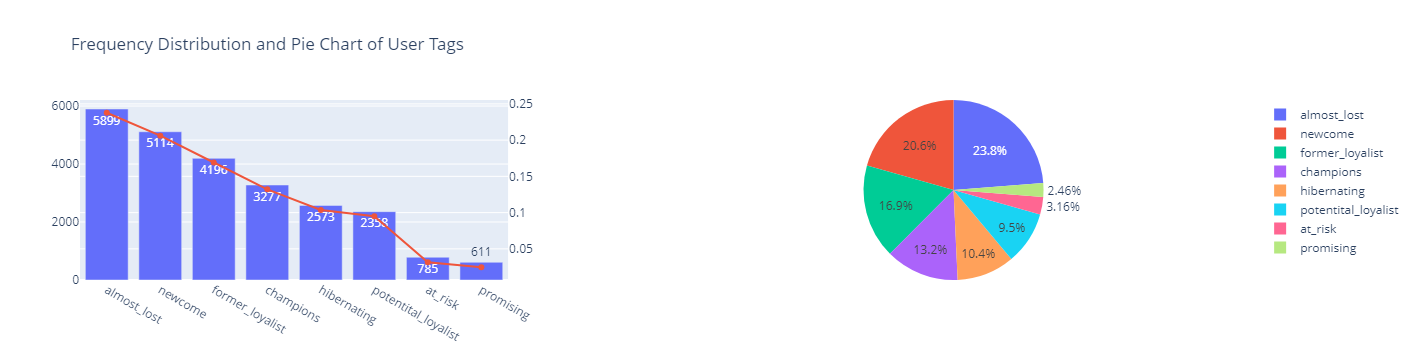

In [325]:
# s = rfm_df3['tags'].value_counts()
# fig = px.bar(s, y=s.values, x=s.index, text_auto='.2s',title="User Tags Distribution") #, subtitle='see how many users in each tag')
# fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
# fig.show()
freq = s / s.sum()
formatted = ['{:.2%}'.format(i) for i in freq.values]
# 创建频率分布直方图
fig1 = go.Figure([go.Bar(x=s.index, y=s.values, text=s.values, hoverinfo='none', textposition='auto', yaxis='y1', showlegend=False),
                  go.Scatter(x=s.index, y=freq, hoverinfo='x+text', text=formatted, mode='lines+markers', yaxis='y2', showlegend=False)])
fig1.update_layout(
    title='Frequency Distribution of User Tags',
    xaxis_title='Tags',
    yaxis_title='User Count',
    yaxis2=dict(title='Segment Percentage', overlaying='y', side='right'), overwrite=True)

fig2 = go.Figure(go.Pie(labels=s.index, values=s.values, showlegend=True))
# test=go.histogram(kde=)
# create a layout with [1,2] grid
fig = make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5], specs=[[{"type": "xy","secondary_y":True}, {"type": "domain"}]]) 
# ↑ has to set "secondary_y":True here to let the below one effective

# add subplots into grid
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1, secondary_y=True)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.update_layout(title_text="Frequency Distribution and Pie Chart of User Tags")

fig.show()

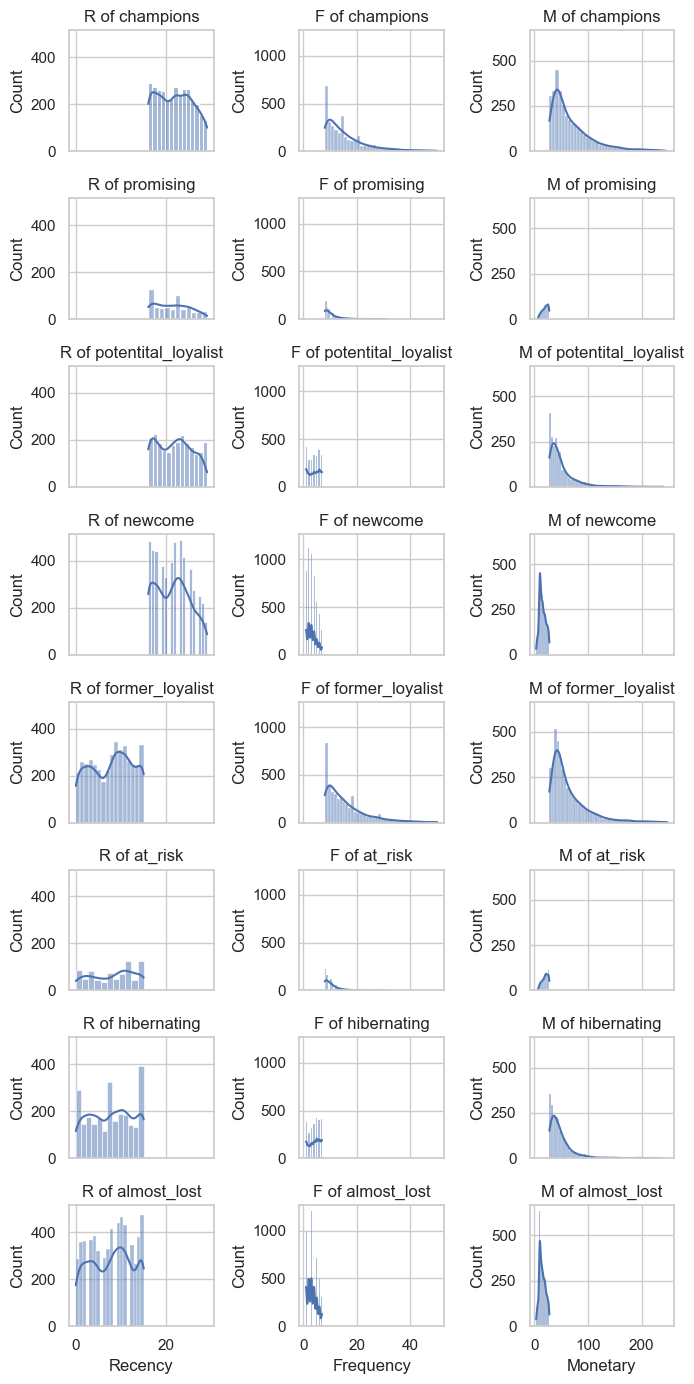

In [454]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(7, 14), sharex='col', sharey='col')
tags = ['champions','promising','potentital_loyalist','newcome','former_loyalist','at_risk','hibernating','almost_lost']
types = ['Recency','Frequency','Monetary']
for r in range(0,8,1):
    for l in range(0,3,1):
        tag = tags[r]
        type = types[l]
        sns.histplot(rfm_df3[rfm_df3['tags']==tag][type], kde=True, ax=axes[r,l]) # bins=30, 
        axes[r,l].set_title(f'{type[0]} of {tag}')
plt.tight_layout()
plt.show()

#### segmentation insights
**For User Refined Operation later:**
- **almost_lost** indicates similar things to churn_rate of which corresponding part of customers has been already included in, which indicates the **unhealthy user structure** of the platform. I need more details of profit/revenue tables from database and ARPU/ARPPU to determine about "unhealthy".
- **champions** are best. I think maybe we can reward them in diverse ways for early utilization of new functions/products and referral in return.
- Providing **potential_loyalists** a higher_grade of membership or loyalty programs like everyday clock for credits or recommend campaigns to upsell them.
- **newcome**  needs us to start building relationships with them. Like onboarding support and special offers for new customers to increase their orders, to form a using habit.
- Sending to **hibernating** personalized reactivation campaigns to reactivate, and offer renewals and helpful products to encourage another purchase.
- Bringing **former_loaylist** back with relevant promotions, and running surveys to find out what went wrong and avoiding losing them to competitors.
- **promising** obviously loves cheaper products, notifying them about the discounts of cart or things they've viewed once in time to keep them spending more and more money on our products

#This is a glimpse of how we can target a customer based on the segmentation which will precisely help in marketing campaigns. Thus saving marketing costs, retaining the customer, making them spend more thereby increasing the revenue. The details are up to the real_world scenarios.

# **PLATFORM ANALYSIS**
_by user_session_
***

## User Engagement

### daily engagement of platform
_daily distribution of user action to see if there's regular pattern in a month 用户行为日分布_

In [ ]:
total_uv=data['user_id'].value_counts()
print(total_uv)
total_uv=len(total_uv)
print('total_uv='+str(total_uv))
total_pv=len(data['user_id'])
print('total_pv='+str(total_pv))

In [ ]:
date=[]
hour=[]

for i in range(0,3533286):
    split_time=str(data['event_time'][i]).split(' ')
    for a in split_time:
        if "-" in a:
            date.append(a)
        elif ":" in a:
            hour.append(a)
#print(date,hour)

In [ ]:
data['date']=date
data['hour']=hour
# del data['event_time']
print(data['date'].tail(10))

In [ ]:
# 日流量指标
daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
daily_uv=data.groupby('date').nunique()['user_id'].reset_index().rename(columns={'user_id':'uv'})
print(daily_pv,'\n',daily_uv)

In [ ]:
ax1=plt.subplot(2,1,1,label='daily_pv')
ax2=plt.subplot(212,sharex=ax1,label='daily_uv')
# fig,axes=plt.subplots(2,1,1,figsize=(12,8),sharex='all')
daily_pv.plot(x='date',y='pv',ax=ax1)
daily_uv.plot(x='date',y='uv',ax=ax2)
plt.xticks(rotation=45,fontsize=12)
ax1.set_title('daily_pv')
ax2.set_title('daily_uv')

### hourly engagement of platform
_timely distribution of user action to see if there exists pattern in a day 用户行为时分布_

In [ ]:
#小时流量指标
# for i in data.columns[:2]:
#     data[i]=data[i].astype('str')
# data['date']=pd.to_datetime(data.date)
# data['hour']=data.hour.astype('int')
hour_int=[]
for i in hour:
    hour_int.append(i[0:2])
# print(hour_int[:10])

In [ ]:
data['hour_int']=hour_int
pv_hour=data[data.event_type=='view'].groupby('hour_int').count()['user_id'].reset_index(drop=True)
uv_hour.columns=['hour','pv']
uv_hour=data.groupby('hour_int').nunique()['user_id'].reset_index(drop=True)   # .rename(columns={'user_id':'uv'})一直显示rename有个unexpected keyword kwarg columns
uv_hour.columns=['hour','uv']
print(pv_hour,'\n',uv_hour)

In [ ]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(12,8),sharex=True)
pv_hour.plot(ax=axes[0])
uv_hour.plot(ax=axes[1])
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes[1].xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

In [ ]:
mean_daily_pv=data[data.event_type=='view'].groupby('date')['user_id'].count().mean()
print('mean_daily_pv='+str('%.2f'%mean_daily_pv))
mean_daily_uv=data.groupby('date').nunique()['user_id'].mean()
print('mean_daily_uv='+str('%.2f'%mean_daily_uv))
mean_daily_gmv=data.groupby('date')['price'].sum().mean()
print('mean_daily_gmv='+str('%.2f'%mean_daily_gmv))
mean_daily_order=data[data.event_type=='purchase'].groupby('date').nunique()['user_session'].values.mean() #series.values访问频数，.index访问索引
print('mean_daily_order='+str('%.0f'%mean_daily_order))
mean_daily_paid_user=data[data.event_type=='purchase'].groupby('date').nunique()['user_id'].mean()
print('mean_daily_paid_user='+str('%.0f'%mean_daily_paid_user))
mean_daily_paid_rate=(mean_daily_paid_user/mean_daily_uv)*100
print('mean_daily_paid_rate='+str('%.2f'%mean_daily_paid_rate)+'%')
mean_daily_ARPU=(mean_daily_gmv/mean_daily_uv)
print('mean_daily_ARPU='+str('%.2f'%mean_daily_ARPU))
mean_daily_ARPPU=(mean_daily_gmv/mean_daily_paid_user)
print('mean_daily_ARPPU='+str('%.2f'%mean_daily_ARPPU))

In [ ]:
mean_daily_pv=data.groupby('date')['user_id'].count().mean()
print('mean_daily_pv='+str('%.2f'%mean_daily_pv))
mean_daily_uv=data.groupby('date').nunique()['user_id'].mean()
print('mean_daily_uv='+str('%.2f'%mean_daily_uv))
mean_daily_gmv=data.groupby('date')['price'].sum().mean()
print('mean_daily_gmv='+str('%.2f'%mean_daily_gmv))
mean_daily_order=data[data.event_type=='purchase'].groupby('date').nunique()['user_session'].values.mean() #series.values访问频数，.index访问索引
print('mean_daily_order='+str('%.0f'%mean_daily_order))
mean_daily_paid_user=data[data.event_type=='purchase'].groupby('date').nunique()['user_id'].mean()
print('mean_daily_paid_user='+str('%.0f'%mean_daily_paid_user))
mean_daily_paid_rate=(mean_daily_paid_user/mean_daily_uv)*100
print('mean_daily_paid_rate='+str('%.2f'%mean_daily_paid_rate)+'%')
mean_daily_ARPU=(mean_daily_gmv/mean_daily_uv)
print('mean_daily_ARPU='+str('%.2f'%mean_daily_ARPU))
mean_daily_ARPPU=(mean_daily_gmv/mean_daily_paid_user)
print('mean_daily_ARPPU='+str('%.2f'%mean_daily_ARPPU))

小结：用户消费行为总览
* 总体指标概览
mean_daily_pv=10000.00
mean_daily_uv=1450.00
mean_daily_gmv=84519.37
mean_daily_order=59
mean_daily_paid_user=59
mean_daily_paid_rate=4.07%
mean_daily_ARPU=58.29
mean_daily_ARPPU=1432.53

（以上是1w条预分析的结论）


* 总体指标概览 :joy:
mean_daily_pv=55752.61
mean_daily_uv=17065.32
mean_daily_gmv=1011187.26
mean_daily_order=934
mean_daily_paid_user=919
mean_daily_paid_rate=5.39%
mean_daily_ARPU=59.25
mean_daily_ARPPU=1100.31
* 从daily_pv&daily_uv图表可以看出，该月内用户量、访问量几乎同幅变动，整体呈现逐渐下降的趋势，在12.2、12.9两个预售日节点有明显小高峰，12.12活动当天达到峰值，紧接着有2-3天的冷却期，之后12.16、12.23有返潮现象
* 周末活跃度明显高于其它工作日，故营销活动或宣发应在周末进行
* 从pv_hour&uv_hour图表可以看出，总体来看19:00-次日2:00的访问量在下降，2:00后开始回升,7:00至正常水平，每日的12:00、19:00达到峰值，反映出午餐及下班后时间更适宜搞平台运营动作
* 用户活跃时段9:00-13:00、17:00-20:00，一般活跃时段13:00-17:00、5:00-9:00，,非活跃时段20:00-5:00

## Conversion Rate in Finer Granularity
_accurate user action flow funnel on consideration of accordant user_id & user_session from beginning to end. 用户行为精准追踪漏斗_

### total conversion rate
_total conversion rate in the user flow path 计算用户流转链路中的总转化率_

In [ ]:
event_type_df

In [ ]:
view=data[data.event_type=='view']
cart=data[data.event_type=='cart']
purchase=data[data.event_type=='purchase']
remove=data[data.event_type=='remove from cart']

In [ ]:
view_num=view.user_id.nunique()
cart_num=cart.user_id.nunique()
purchase_num=purchase.user_id.nunique()
remove_num=remove.user_id.nunique()
view_num

In [ ]:
funnel_data=[("浏览",view_num),("加购",cart_num),("付费",purchase_num)]
(Funnel(init_opts=opts.InitOpts(width='500px',height='300px')).add(
    "type",data_pair=funnel_data,label_opts=opts.LabelOpts(),gap=1,tooltip_opts=opts.TooltipOpts(is_show=True)).set_global_opts(
        title_opts=opts.TitleOpts(title="用户转化漏斗",subtitle="process:浏览-加购-付费"))
).render_notebook()

In [ ]:
# 计算总转化率（即默认用户先浏览后加购后购买）
purchase_user=data[data.event_type=='purchase'].user_id.nunique()
remove_user=data[data.event_type=='remove_from_cart'].user_id.nunique()
print('浏览后加购率%.2f%%'%((cart_user/view_user)*100))
print('加购后付费率%.2f%%'%((purchase_user/cart_user)*100))
print('加购后移除率%.2f%%'%((remove_user/cart_user)*100))
print('总uv中浏览人占比%.2f%%'%((view_user/total_uv)*100))
print('总uv中加购人占比%.2f%%'%((cart_user/total_uv)*100))
print('总uv中购买人占比%.2f%%'%((purchase_user/total_uv)*100))

小结：用户转化漏斗分析
* ps此处的处理方式是由于①并未能保证用户均是按照理想链路流转，因此不能直接除以，需要合并求交叉值，并控制时间先后才能确保结果是我们所需的“精准”的流转链路。
* 进一步释义：合并后的记录有630243条，这意味着有（927124-630243）位用户是未浏览详情页直接加购的，view2cart_user=52979，有（630243-52979）位用户不是在周期内形成view→cart完整链路的。
* 层级转化率：浏览的人中有14.79%加购，加购的人中有30.17%付费，浏览的人中有5.94%直接付费。
* 总转化率中用“模糊”形式得到了23.30%和30.69%，相对来说都是偏大的。
* 总活跃用户中各种行为的uid占比，结合前方的层级转化可见，大部分用户还是停留在浏览的一个阶段，需要运营在该转化节点加力。对应举措（1）运营多多筹办积分活动、会员活动、促销活动等促使用户尽快加购付费；（2）用户增长可以拓展站外流量来源，增加点击量；（3）产品可以增加醒目的加购提醒或降价/秒杀消息通知等。

### level conversion rate 
_conversion rate of each level, in finer granularity, in the user flow path 计算用户流转链路中的层级转化率_

In [ ]:
view2cart=pd.merge(left=view,right=cart,how='inner',on=['user_id','product_id'],suffixes=("_view","_cart"))
cart2purchase=pd.merge(left=cart,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_cart","_purchase"))
view2purchase=pd.merge(left=view,right=purchase,how='inner',on=['user_id','product_id'],suffixes=("_view","_purchase"))
view2cart

In [ ]:
# view2cart['event_time_view']=pd.toDatetime()
view2cart_user=view2cart[view2cart.event_time_view<view2cart.event_time_cart].user_id.nunique()
cart2purchase_user=cart2purchase[cart2purchase.event_time_cart<cart2purchase.event_time_purchase].user_id.nunique()
view2purchase_user=view2purchase[view2purchase.event_time_view<view2purchase.event_time_purchase].user_id.nunique()
print(view2cart_user,cart2purchase_user,view2purchase_user)
view_user=data[data.event_type=='view'].user_id.nunique()
cart_user=data[data.event_type=='cart'].user_id.nunique()
# 计算层级转化率
view2cart_rate=view2cart_user/view_user
cart2purchase_rate=cart2purchase_user/cart_user
view2purchase_rate=view2purchase_user/view_user
print('浏览加购层级转化率%.2f%%'%(view2cart_rate*100))
print('加购付费层级转化率%.2f%%'%(cart2purchase_rate*100))
print('浏览付费层级转化率%.2f%%'%(view2purchase_rate*100))

In [ ]:
print(user_event_count)

## Retention Rate
_partion of users keeping active in a time range, standing for appeal to users 一定时间内保持活跃状态的用户比例，反映产品和平台服务的的吸引力_
- 7d_rtt
- 15d_rtt
- 30d_rtt

## User Stickiness
_using frequency and duration of platform, standing for dependency degree of users 对产品或服务的使用频率和持续时间_
- using frequency: event_times not buy_times
- duration of platform: event lifespan not purchase lifespan defined earlier

# **BRAND AND PRODUCT ANALYSIS**
_by brand/product_id_
***

## Performance of Brands
- heat = how times a brand appeared in the event_table and how many customers engaged with it
- spec_times = specific times in view/cart/purchase of a brand
- user_loyalty = user_buy_times of each brand
- order_value = how much gmv a brand create
- profitability (need product_tb with profit from database)

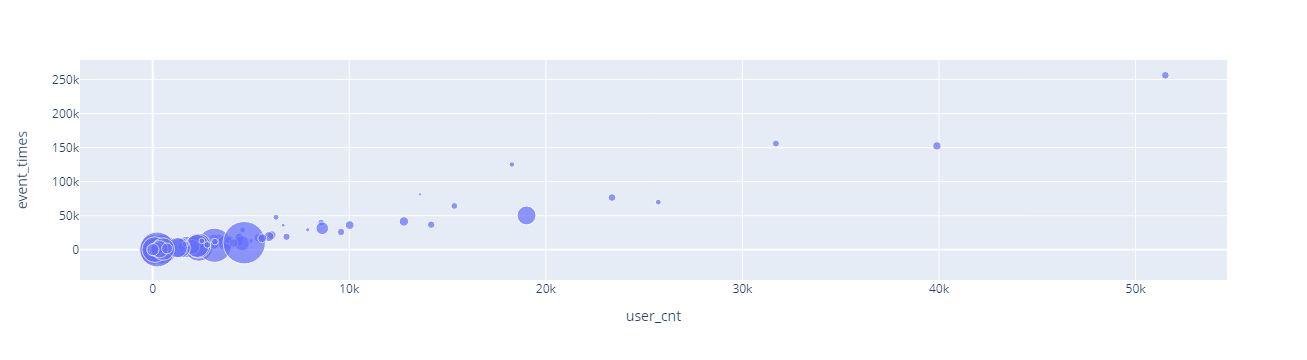

In [770]:
brand_df = data[data.brand!='null'].groupby('brand').agg({'product_id': 'count', 'price': 'mean', 'user_id': pd.Series.nunique}) # , 'category_id': lambda x: ','.join(x.unique())

fig = px.scatter(brand_df, x='user_id', y='product_id', size="price", labels={'product_id':'event_times','user_id':'user_cnt'}, hover_name=brand_df.index, size_max=30)
# hover_data={'price': True}, color="continent",  log_x=True,
fig.show()

In [ ]:
avg_view
avg_cart
avg_buy

### problematic brands
_brands that have many views and few carts or many views and few purchase or many carts and few purchase, need more attention and training from Marketing Department 某一环节卡住的品牌，需要市场部门重点“辅导”和助推_

### KA list for brands
_those brands with higher 

In [ ]:
data.groupby('brand')['user_id'].value_counts()

## Performance of Products
- heat= how times a product appeared in the event_table
- spec_times = specific times in view/cart/purchase of a product
- user_loyalty = user_buy_times of each product
- order_value = how much gmv a product create

In [ ]:
avg_view
avg_cart
avg_buy

### busket analysis by corr

小结：用户消费行为总览（按日维度）
* 总体指标总览
mean_daily_pv=10000.00
mean_daily_uv=1450.00
mean_daily_gmv=84519.37
mean_daily_order=59
mean_daily_paid_user=59
mean_daily_paid_rate=4.07%
mean_daily_ARPU=58.29
mean_daily_ARPPU=1432.53
* 从daily_pv&daily_uv图表可以看出，该月内用户量、访问量整体呈现缓慢攀升的趋势，在双十二达到峰值
* 从hourly_pv&hourly_uv图表可以看出，总体来看23:00与次日5:00的访问量在下降，5:00后开始回升至正常水平，18:00-22:00访问量有明显提升，并在21:00-22:00达到峰值，用户量的趋势类似但不那么明显；区分用户活跃时段，一般活跃时段及非活跃时段

# **SUMMARY**

**Thanks so much for your time and consideration!**

**I don't actually need to analyze one dataset from so many dimensions in the normal daily working process but according to demands from Colleague Departments. I did it here to present as many angles as I can to show the structured thinking way. I've given too many divergent tasks in the previous analysis that I couldn't finish them all completely for the time being. Some questions require more datasets to answer. In the future spare time, I will slowly answer them all I've asked myself.**

**You can reach me by dingbangchu@gmail.com anytime.**